# Pregunta 1, parte 1

## Importacion

Se importa el módulo `pandas`, y se importa un módulo personal llamado `paths`, que contiene los paths que utilizaremos en este análisis.

In [1]:
import pandas as pd

from paths import *

Esta es la documentación de `paths` (decomentar para verlas).

In [2]:
# Documentación del módulo 'paths'.
# import paths
# help(paths)

## Carga de datos

### Creación de la tabla mezclada

Cargar todos los .csv en dos listas distinguidas por la aparición de `furnished` en el nombre.

In [3]:
# Lista de DataFrames (Sin 'furnished' en el nombre)
L_DF_a = [pd.read_csv(dict_csv_mc_a[wNN]) for wNN in L_WNN]

# Lista de DataFrames (Con 'furnished' en el nombre)
L_DF_f = [pd.read_csv(dict_csv_mc_f[wNN]) for wNN in L_WNN]

Se unen los `DataFrames` de las listas en un único `DataFrame`, luego se crea una nueva columna llamada `'furnished'` y finalmente se unen los dos `DataFrames` en uno, con la nueva columna incluida.

In [4]:
# se unen todos los data_frame en cada lista con el comando concat
DF_a = pd.concat(L_DF_a)
DF_f = pd.concat(L_DF_f)

# Se eliminan las filas duplicadas de cada data frame por separado
DF_a.drop_duplicates(subset=DF_a.columns, ignore_index=True, inplace=True, keep='last')
DF_f.drop_duplicates(subset=DF_f.columns, ignore_index=True, inplace=True, keep='last')

# Se crea una columna con tantos ceros como la cantidad de filas de DF_a
# y con tantos unos como la cantidad de filas de DF_f 
furnished_col = pd.DataFrame(data={'furnished':[0]*(DF_a.shape[0]) + [1]*(DF_f.shape[0])})

# Concateno los data frames DF_a y DF_f y le agrego al final la columna furnished_col
df = pd.concat([DF_a, DF_f], ignore_index=True) 
df = pd.concat([df, furnished_col], axis=1)

In [5]:
# vemos cuantas filas tiene cada data frame (para reportar si hay filas en furnished 
# que no estan en all)
# print(DF_a.shape[0])
# print(DF_f.shape[0])
# nota: DF_a tiene 16295 filas y DF_f tiene 2099 filas  

Para terminar, se quitan las filas duplicadas en ambos grupos, furnished y all

In [6]:
# Quitamos las filas que sean iguales en todas las columnas con excepcion de
# la columna furnished y reindexamos
df.drop_duplicates(subset=df.columns[:-1], ignore_index=True, inplace=True, keep='last')

# comentario 1: si hay filas duplicadas con distintos valores de furnished, se eliminan las primera
# comentario 2: el comentario 1 asegura que si hay dos filas iguales con distintos valores de furnished,
# se elimine la que tiene el valor 0 para furnished, lo que tiene sentido dado que furnished puede estar
# contenido en all

In [7]:
# reportar si Reporte si existen observaciones de archivos con texto ’furnished’ que no estén
# contenidos en archivos con texto ’all’
# print(df[df['furnished'] == 0].shape[0])
# print(df[df['furnished'] == 1].shape[0])
# como ambas selecciones de filas en el dataframe tienen las mismas filas que los originales
# luego de eliminar las filas iguales, se conluye que no hay filas en furnished que no esten
# en all

## Pregunta 1, parte 2

### a) Limpieza de datos

Se crea un diccionario llamado `valores_nulos` que contendrá el nombre de las columnas de `df` como llave, y el valor de la llave será lo que reemplazará el valor `NaN`.

In [8]:
# Creamos valores a reemplazar
valores_nulos = {
#     'property_type|rent_type|location':'Sin nombre',
    'price':'$0',
    'n_rooms':'NA',
    'n_bath':'NA',
    'surface':'0.0 m2',
#     'details':'',
#     'url':'',
#     'metrocuadrado_index':0.0,
#     'furnished':0
}

In [9]:
# Reemplazamos los valores
df.fillna(value=valores_nulos, inplace=True)

#### Reemplazo de los tipos de algunas columnas

Además, en esta etapa se cambiará el tipo de algunas columnas.

##### Funciones auxiliares

In [10]:
# Función que mapeará la columna `price`
def precio_to_int(s:str)->int:
    """
    Toma un precio en forma de `str`, en el formato `'$XXX.XXX.XXX'` 
    con X algún número, y retorna el número entero de ese precio.
    """
    return int(s.replace('$', '').replace('.', ''))

# Función que mapeará la columna `surface`
def n_surface(s:str)->float:
    """
    Toma un `str` en formato "XX.Xm2" y retorna el número real con los metros cuadrados.
    """
    return float(s.replace('m2', ''))

##### Reemplazo de columnas

In [11]:
# Columna de precios
precios_col = df['price'].map(precio_to_int)
# Columna de superficie
superficie_col = df['surface'].map(n_surface)

df['price'] = precios_col
df['surface'] = superficie_col
df.rename(columns={
    'price':'price_$',
    'surface':'surface_m2'
}, inplace=True)

### b) Obtención de 3 columnas a partir de `'property_type|rent_type|location'`

`lower_case_col` es una columna con todas las palabras en minusculas.

In [12]:
lower_case_col = df['property_type|rent_type|location'].str.lower()

#### Columna `tipo de inmueble`

In [13]:
# `casa_bool_col` y `apart_bool_col` son columnas que tienen un -1 si la palabra no está 
# y un número entero positivo si la palabra está.
casa_bool_col = lower_case_col.str.find('casa')
apart_bool_col = lower_case_col.str.find('apartamento')

# Se crea una lista con la infomacion del tipo de inmueble recorriendo las dos columnas anteriores
tipo_inm_list = []
for index in range(len(lower_case_col)):
    if casa_bool_col[index] >= 0:
        tipo_inm_list.append('Casa')
    elif apart_bool_col[index] >= 0:
        tipo_inm_list.append('Apartamento')
    else:
        tipo_inm_list.append('No hay info')

# columna de tipo de inmueble
tipo_inm_col = pd.DataFrame(data = {'tipo_de_inmueble': tipo_inm_list})

# Nota: no hay columnas que no tengan una de las dos informaciones

#### Columna `Tipo de oferta`



In [14]:
# `vent_bool_col` y `arr_bool_col` son columnas que tienen un -1 si la palabra no está 
# y un número entero positivo si la palabra está.
vent_bool_col = lower_case_col.str.find('venta')
arr_bool_col = lower_case_col.str.find('arriendo')

# Se crea una lista con la infomacion del tipo de oferta recorriendo las dos columnas anteriores
tipo_ofer_list = []
for index in range(len(lower_case_col)):
    if (vent_bool_col[index] >= 0) and (arr_bool_col[index] >= 0):
        tipo_ofer_list.append('Arriendo y venta')
    elif arr_bool_col[index] >= 0:
        tipo_ofer_list.append('Arriendo')
    else:
        tipo_ofer_list.append('No hay info')

# columna de tipo de oferta
tipo_ofer_col = pd.DataFrame(data = {'tipo_de_oferta': tipo_ofer_list})

# Nota: no hay columnas que no tengan una de las dos informaciones

#### Columna `location`



In [15]:
# `sep_comas` es una serie que contiene en cada elemento una lista del string correspondiente 
# que separa por comas los grupos de strings
sep_comas = df['property_type|rent_type|location'].str.split(pat = ",")

# Se crea una lista con la infomacion location recorriendo los segundos elementos de la columna anterior
# se asume que la direccion esta al final de cada string
location_list = []
for index in range(len(sep_comas)):
    lista_strings = sep_comas[index]
    location_list.append(lista_strings[1]) 
    
# columna location
location_col = pd.DataFrame(data = {'location': location_list})

#### Agregar las 3 columnas anteriores a `df`

In [16]:
df = pd.concat([df,tipo_inm_col], axis=1)
df = pd.concat([df,tipo_ofer_col], axis=1)
df = pd.concat([df,location_col], axis=1)

In [17]:
# prueba de que location_col no tiene el string de arriendo (solo tiene direcciones)
# prueba_0 = location_col['location'].str.lower()
# prueba_1 = prueba_0.str.find('arriendo')
# for index in range(len(prueba_1)):
#     if prueba_1[index] >= 0:
#         print('error')

## Pregunta 1, parte 3

### Esquema para agregar las columnas `price per m2` y `garajes`

* Se desarrollarán funciones que procesen las columnas `url`.
* Se crearán nuevas columnas a partir de las columnas mapeadas a partir de las funciones creadas.
* Se agregarán estas columnas a `df`.

#### Funciones

Se detallan las funciones que mapearán las columnas a continuación:

In [18]:
# Función que mapeará la columna `url`
def n_garaje(s:str)->str: 
    """
    Función que toma una url en forma de `str` y retorna un `str`, que será
    el número de garajes para la vivienda de esa url.
    """
    i_garaje = s.find('-garajes')
    
    # No se encuentra el garaje
    if i_garaje is -1: 
        return '0'
    
    # rescata el str con el número. Puede ser un número de la forma '4+'
    s_hasta_garaje = s[:i_garaje] # Se recortará el str hasta la aparición de '-garajes'
    i_garaje_ = s_hasta_garaje.rfind('-') + 1 # Se encontrará el índice siguiente de un guión '-'
    
    return s_hasta_garaje[i_garaje_:] # Se entrega el resto después de ese índice

#### Procesamiento de columnas

Se crearán las columnas y se procesarán para ser entregadas.

In [19]:
#columna de los garajes
garajes_col = df['url'].map(n_garaje)

# Columna producto de la división entre las columnas de precio y superficie
p_por_s_col = (df['price_$'] / df['surface_m2']).map(lambda x: round(x, 2))

#### Rotulación de columnas y añadirlas a `df`

In [20]:
df_ppm_and_g = pd.DataFrame(
    data={
        'price_per_m2_$/m2':p_por_s_col,
        'garajes':garajes_col
    }
)

df = pd.concat([df, df_ppm_and_g], axis=1)

## Pregunta 1, parte 4

### Esquema para clasificar:

In [21]:
# crear las 8 clasificaciones con el comando query, ademas, se crean columnmas con enteros 
# que representan dicha clasificacion

expr_base = 'tipo_de_inmueble == "{tipo_inmueble}" ' \
          + 'and surface_m2 >= {cota_inf} ' \
          + 'and surface_m2 {desig} {cota_sup}'

L_inmuebles = ['Casa']*5 + ['Apartamento']*3
bnds_sym_r = ['<']*4 + ['<='] \
           + ['<']*2 + ['<=']

L_bnds_casa = list(map(str, [80, 120, 180, 240, 360, 460]))
L_bnds_apart = list(map(str, [40, 60, 80, 120]))

bnds = [(L_bnds_casa[i], L_bnds_casa[i+1]) for i in range(len(L_bnds_casa)-1)] \
     + [(L_bnds_apart[i], L_bnds_apart[i+1]) for i in range(len(L_bnds_apart)-1)]

L_expr = [expr_base.format(
    tipo_inmueble=L_inmuebles[i], 
    cota_inf=bnds[i][0], 
    desig=bnds_sym_r[i], 
    cota_sup=bnds[i][1]
) for i in range(len(bnds))]

In [22]:
L_prod = []
tipo_prod_list = []

for i in range(len(L_expr)):
    prod = df.query(L_expr[i], inplace=False)
    list_prod = [i+1]*(prod.shape[0])
    
    L_prod.append(prod)
    tipo_prod_list += list_prod

# concateno todos los productos reseteando los indices
df = pd.concat(L_prod, ignore_index=True) 
# creo la columna con el tipo de producto
tipo_prod = pd.DataFrame(data={'Tipo_de_prod': tipo_prod_list})
# agrego la columna de tipo de producto
df = pd.concat([df, tipo_prod], axis=1)

## Pregunta 1, parte 5

In [23]:
# Cargar data
df_upz = pd.read_csv(path_csv_barrio_upz)

In [24]:
# se crea la columna location que es la columna 'location' de df, a la que 
# se le cambian todas las letras por minusculas y se le hace un split 
# para ver las palabras enlistadas   
location = df['location'].str.lower()
location = location.str.split(pat=" ")

# se crea la columna pro_location que es la columna 'pro_location' de df_upz, a la que 
# se le cambian todas las letras por minusculas y se le hace un split 
# para ver las palabras enlistadas   
pro_location = df_upz['pro_location'].str.lower()
pro_location = pro_location.str.split(pat=" ")

In [25]:
# Se crea una lista con los codigos de upz de df_upz que corresponden a cada fila de df
# en caso de que no se encuentre ningun representante en df_upz, se pone un -1
# Se usa el hecho de que uan fila en df se puede asignar a lo mas a una fila en upz 
# (algoritmo celda siguiente)
upz_list = []

# Se elige un elemento (lista por el split) de location
for name_df_completo in location:
    # Se acorta para sacar el primer elemento (['']) y el los dos ultimos (['Bogota', 'D.C..'])
    name_df = name_df_completo[1:-2] 
    # se fija un indice inicial para iterar sobre todos los indices de df_upz hasta encontrar
    # un representante
    indice_upz = 0  
    index_encontrado = False 
    while not(index_encontrado) and indice_upz < len(pro_location):
        # nos aseguramos que es una lista desde el split y no un 'nan'
        if type(pro_location[indice_upz]) is list:
            # vemos si pro_location[indice_upz] es el representante 
            if pro_location[indice_upz] == name_df:
                # en este caso paramos el loop
                index_encontrado = True 
            # sino, se continua con el otro indice 
            else:
                indice_upz = indice_upz + 1
        # sino, se continua con el otro indice 
        else:
            indice_upz = indice_upz + 1 
    # Luego terminar el loop, tenemos dos casos
    # se encontro un indice
    if index_encontrado:
        upz_list.append(df_upz['UPlCodigo'][indice_upz]) 
    else:
        upz_list.append(-1)

In [26]:
# crear columna de codigo upz y agregar al dataframe df
upz_code = pd.DataFrame(data={'upz_codigo': upz_list})
df = pd.concat([df, upz_code], axis=1)

In [27]:
# Numero de observaciones que no tienen codigo upz asignado
print('Numero de observaciones sin codigo upz asignado:', df[df['upz_codigo'] == -1].shape[0])

Numero de observaciones sin codigo upz asignado: 1713


In [28]:
# barrios que no tienen codigo upz asigando (sin repeticion por el set)
barrios = set((df[df['upz_codigo'] == -1]['location']).tolist())
# Numero de barrios sin codigo upz
print('Numero de barrios sin codigo upz:', len(barrios))

Numero de barrios sin codigo upz: 150


In [29]:
# Seleccionar solo las observaciones que tienen codigo upz
df = df[df['upz_codigo'] != -1] 
df.reset_index(inplace = True)
df = df[df.columns[1:]]

## Pregunta 1, parte 6

In [30]:
# cargar data estadisticas_poblacion.csv
df_poblacion = pd.read_csv(dict_csv_est_upz['estadisticas_poblacion'])
# cargar data indice_inseguridad.csv
df_inseg = pd.read_csv(dict_csv_est_upz['indice_inseguridad'])
# cargar data porcentaje_areas_verdes.csv
df_a_verdes = pd.read_csv(dict_csv_est_upz['porcentaje_areas_verdes'])

In [31]:
# crear columna con indice de inseguridad
ins_list = []
for index_df in range(df.shape[0]):
    upz_code = df['upz_codigo'][index_df]
    # Si hay exactamente 1 indice de inseguridad para la observacion la agrego
    if df_inseg[df_inseg['UPlCodigo'] == upz_code].shape[0] == 1:
        ins_ind = df_inseg[df_inseg['UPlCodigo'] == upz_code]['indice_inseguridad'].iloc[0]
        ins_list.append(ins_ind)
    # Si no, agrego un -1 a la lista 
    else:
        print('Caso raro reportado')
        ins_list.append(-1)

Caso raro reportado


In [32]:
# Nota: hay una observacion a la que no se puede agregar indice de inseguridad

# Se crea la columna, se agrega al data frame, y se quita la observacion con
# indice de inseguridad -1
ins_ind = pd.DataFrame(data={'Indice_inseguridad': ins_list})
df = pd.concat([df, ins_ind], axis=1)
# Se quita la observaion y se resetean los indices
df = df[df['Indice_inseguridad'] != -1] 
df.reset_index(inplace = True)
df = df[df.columns[1:]]

In [33]:
# crear columna con indice de areas_verdes_perc
areas_list = []
for index_df in range(df.shape[0]):
    upz_code = float(df['upz_codigo'][index_df][3:])
    # Si hay exactamente 1 indice de inseguridad para la observacion la agrego
    if df_a_verdes[df_a_verdes['cod_upz'] == upz_code].shape[0] == 1:
        areas_ind = df_a_verdes[df_a_verdes['cod_upz'] == upz_code]['areas_verdes_perc'].iloc[0]
        areas_list.append(areas_ind)
    # Si no, agrego un -1 a la lista 
    else:
        print('Caso raro reportado')
        areas_list.append(-1)

In [34]:
# Se crea la columna, se agrega al data frame (no se quita el -1 porque no hay)
areas_col = pd.DataFrame(data={'areas_verdes_perc': areas_list})
df = pd.concat([df, areas_col], axis=1)

In [35]:
# crear columnas con datos del data frame df_poblacion
# como son 7 columnas, se les llamara solo por sus indices
list_0_col = []
list_1_col = []
list_2_col = []
list_3_col = []
list_4_col = []
list_5_col = []
list_6_col = []

for index_df in range(df.shape[0]):
    upz_code = df['upz_codigo'][index_df]
    # Si hay exactamente 1 indice de inseguridad para la observacion la agrego
    if df_poblacion[df_poblacion['upz'] == upz_code].shape[0] == 1:
        dato_0 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[3]].iloc[0]
        list_0_col.append(dato_0)
        dato_1 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[4]].iloc[0]
        list_1_col.append(dato_1)
        dato_2 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[5]].iloc[0]
        list_2_col.append(dato_2)
        dato_3 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[6]].iloc[0]
        list_3_col.append(dato_3)
        dato_4 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[7]].iloc[0]
        list_4_col.append(dato_4)
        dato_5 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[8]].iloc[0]
        list_5_col.append(dato_5)
        dato_6 = df_poblacion[df_poblacion['upz'] == upz_code][df_poblacion.columns[9]].iloc[0]
        list_6_col.append(dato_6)
    # Si no, agrego un -1 a la lista 
    else:
        print('Caso raro reportado')
        list_0_col.append(-1)
        list_1_col.append(-1)
        list_2_col.append(-1)
        list_3_col.append(-1)
        list_4_col.append(-1)
        list_5_col.append(-1)
        list_6_col.append(-1)

In [36]:
# Se crean las columnas, se agrega al data frame (no se quita el -1 porque no hay)
col_0 = pd.DataFrame(data={df_poblacion.columns[3]: list_0_col})
df = pd.concat([df, col_0], axis=1)
col_1 = pd.DataFrame(data={df_poblacion.columns[4]: list_1_col})
df = pd.concat([df, col_1], axis=1)
col_2 = pd.DataFrame(data={df_poblacion.columns[5]: list_2_col})
df = pd.concat([df, col_2], axis=1)
col_3 = pd.DataFrame(data={df_poblacion.columns[6]: list_3_col})
df = pd.concat([df, col_3], axis=1)
col_4 = pd.DataFrame(data={df_poblacion.columns[7]: list_4_col})
df = pd.concat([df, col_4], axis=1)
col_5 = pd.DataFrame(data={df_poblacion.columns[8]: list_5_col})
df = pd.concat([df, col_5], axis=1)
col_6 = pd.DataFrame(data={df_poblacion.columns[9]: list_6_col})
df = pd.concat([df, col_6], axis=1)

In [37]:
# Para crear la columna de densidad de poblacion tomamos el valor 
# UPlArea y lo dividimos por el numero de personas
upz_area_list = []
for index_df in range(df.shape[0]):
    upz_code = df['upz_codigo'][index_df]
    # Dato de area del dataframe df_upz
    upz_area = (df_upz[df_upz['UPlCodigo'] == upz_code])['UPlArea'].iloc[0]
    # Numero de personas
    num_personas = df['personas'][index_df]
    # densidad
    densidad = upz_area/num_personas 
    # lo agrego a la lista 
    upz_area_list.append(densidad)

In [38]:
# Se crea la columna densidad y se agrega al data frame 
dens_col = pd.DataFrame(data={'densidad': upz_area_list})
df = pd.concat([df, dens_col], axis=1)

In [40]:
# Guardo el data_frame en una carpeta llamada data_limpia en la carpeta data
# df.to_csv(path_csv_limpio)

In [ ]:
# Fin del codigo P1

In [41]:
df.head()

,property_type|rent_type|location,price_$,n_rooms,n_bath,surface_m2,details,url,metrocuadrado_index,furnished,tipo_de_inmueble,...,Indice_inseguridad,areas_verdes_perc,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,densidad
0,"Casa en Arriendo, SANTA ANA ORIENTAL Bogotá D.C..",2700000,2,2,90.0,La ubicación exacta de la propiedad no se publ...,https://www.metrocuadrado.com/inmueble/arriend...,55.9,0,Casa,...,2.505219,45.988424,115124,1.5,2.0,5.2,127.3,38.443910,3.840225,42.796635
1,"Casa en Arriendo, ESTACION VICTORIA Bogotá D.C..",1500000,3,2,90.0,"Excelente Jardin, Parqueadero interno a la cas...",https://www.metrocuadrado.com/inmueble/arriend...,28.7,0,Casa,...,11.157025,32.151794,24897,0.1,8.4,7.9,24.7,26.367889,6.688596,191.831725
2,"Casa en Arriendo, AUTOPISTA MUZU Bogotá D.C..",1300000,4,2,90.0,"Entrada con puerta metalica, sala comedor, coc...",https://www.metrocuadrado.com/inmueble/arriend...,38.8,0,Casa,...,2.240896,26.057273,50106,1.7,30.6,13.5,62.1,38.518565,14.005861,50.457441
3,"Casa en Arriendo, SANTA ANA OCCIDENTAL Bogotá ...",1800000,2,3,100.0,"Casa muy bien ubicada, amplia con opción para ...",https://www.metrocuadrado.com/inmueble/arriend...,49.8,0,Casa,...,2.505219,45.988424,115124,1.5,2.0,5.2,127.3,38.443910,3.840225,42.796635
4,"Casa en Arriendo, SANTA BARBARA Bogotá D.C..",850000,3,2,84.0,Oportunidad casa No Conjunto Residencial Lago...,https://www.metrocuadrado.com/inmueble/arriend...,29.0,0,Casa,...,3.383459,18.205454,22440,0.2,9.3,16.7,91.2,40.729156,16.182676,91.811195


# Pregunta 2 
## parte 1

### Importaciones

In [83]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import stats

#### Diccionario de configuraciones
Ver [seaborn.plotting_context](https://seaborn.pydata.org/generated/seaborn.plotting_context.html) para mayor información.

In [3]:
dicc_context = {
    'font.size': 16.0,
    'axes.labelsize': 18.0,
    'axes.titlesize': 18.0,
    'xtick.labelsize': 16.5,
    'ytick.labelsize': 16.5,
    'legend.fontsize': 16.5,
    'axes.linewidth': 1.25,
    'grid.linewidth': 1.0,
    'lines.linewidth': 1.5,
    'lines.markersize': 6.0,
    'patch.linewidth': 1.0,
    'xtick.major.width': 1.25,
    'ytick.major.width': 1.25,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,
    'xtick.major.size': 6.0,
    'ytick.major.size': 6.0,
    'xtick.minor.size': 4.0,
    'ytick.minor.size': 4.0
}

cont = sns.plotting_context(dicc_context)

#### Función de formato

Ocupa la función [seaborn.set](https://seaborn.pydata.org/generated/seaborn.set.html)

In [4]:
def formato():
    sns.set(
        context=cont,
        style='whitegrid',
        palette='deep',
    )
    return None

#### Prueba

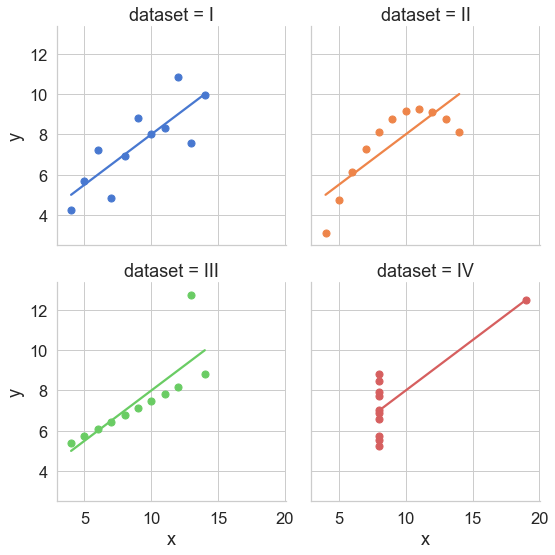

In [5]:
formato()
df = sns.load_dataset("anscombe")
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

In [6]:
###### PARTE 2
# Se importa el modulo con los paths de archivos
from paths import *

In [7]:
# Cargar datos limpiados de la parte 1
df= pd.read_csv(path_csv_limpio)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13917 entries, 0 to 13916
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               13917 non-null  int64  
 1   property_type|rent_type|location         13917 non-null  object 
 2   price_$                                  13917 non-null  int64  
 3   n_rooms                                  13889 non-null  object 
 4   n_bath                                   13779 non-null  object 
 5   surface_m2                               13917 non-null  float64
 6   details                                  13879 non-null  object 
 7   url                                      13917 non-null  object 
 8   metrocuadrado_index                      13917 non-null  float64
 9   furnished                                13917 non-null  int64  
 10  tipo_de_inmueble                         13917

In [9]:
object_type_set = [col for col in df.columns if df[col].dtype == 'O']

In [10]:
df = df.astype({col:'str' for col in object_type_set})

In [11]:
names = ['numeric', 'categorical']

# Se crea una lista con las columnas numericas

numeric_continuas = ['metrocuadrado_index','densidad','adultos_mayores_pobres_perc','jefe_mujer_perc','indice_envegecimiento',
           'price_$','surface_m2','price_per_m2_$/m2',
           'Indice_inseguridad','areas_verdes_perc','jovenes_14_24_anos_nini_perc','trabajoinfampliado_ninos_5_17_anos_perc',
           'trabajoinf_ninos_5_17_anos_perc']

numeric_discretas=['n_rooms','n_bath','garajes','personas'] 

strings=['url','upz_codigo']


# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric_continuas)-set(numeric_discretas)-set(strings))

mapping = [('numeric_continuas', col) for col in numeric_continuas]

mapping.extend([('categorical', col) for col in categorical])

mapping.extend([('numeric_discretas', col) for col in numeric_discretas])

mapping.extend([('strings', col) for col in strings])

In [12]:
df = df.reindex(columns=numeric_continuas + categorical+numeric_discretas+strings)

In [13]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)
df

numeric_continuas                                          \
      metrocuadrado_index    densidad adultos_mayores_pobres_perc   
0                    55.9   42.796635                    3.840225   
1                    28.7  191.831725                    6.688596   
2                    38.8   50.457441                   14.005861   
3                    49.8   42.796635                    3.840225   
4                    29.0   91.811195                   16.182676   
...                   ...         ...                         ...   
13912                73.7   79.780854                    5.401917   
13913                64.2   39.843848                    3.840225   
13914                55.4   79.780854                    5.401917   
13915                59.1   39.843848                    3.840225   
13916                68.9   49.729352                    2.615948   

                                                                 \
      jefe_mujer_perc indice_envegecimiento  price_$ surface_m2   
0           38.443910                 127.3  2700000       90.0   
1           26.367889                  24.7  1500000       90.0   
2           38.518565                  62.1  1300000       90.0   
3           38.443910                 127.3  1800000      100.0   
4           40.729156                  91.2   850000       84.0   
...               ...                   ...      ...        ...   
13912       44.667815                 153.4  5000000      115.0   
13913       38.443910                 127.3  4390000      110.0   
13914       44.667815                 153.4  4500000      120.0   
13915       38.443910                 127.3  4100000      114.0   
13916       39.046371                  70.5  3800000      107.0   

                                                              ...  \
      price_per_m2_$/m2 Indice_inseguridad areas_verdes_perc  ...   
0              30000.00           2.505219         45.988424  ...   
1              16666.67          11.157025         32.151794  ...   
2              14444.44           2.240896         26.057273  ...   
3              18000.00           2.505219         45.988424  ...   
4              10119.05           3.383459         18.205454  ...   
...                 ...                ...               ...  ...   
13912          43478.26           2.047782         20.901367  ...   
13913          39909.09           1.161103         25.466350  ...   
13914          37500.00           2.047782         20.901367  ...   
13915          35964.91           1.161103         25.466350  ...   
13916          35514.02           3.794038         39.319972  ...   

                                             categorical             \
                        property_type|rent_type|location Unnamed: 0   
0      Casa en Arriendo, SANTA ANA ORIENTAL Bogotá D.C..          0   
1       Casa en Arriendo, ESTACION VICTORIA Bogotá D.C..          1   
2          Casa en Arriendo, AUTOPISTA MUZU Bogotá D.C..          2   
3      Casa en Arriendo, SANTA ANA OCCIDENTAL Bogotá ...          3   
4           Casa en Arriendo, SANTA BARBARA Bogotá D.C..          4   
...                                                  ...        ...   
13912   Apartamento en Arriendo, LA CABRERA Bogotá D.C..      13912   
13913  Apartamento en Arriendo, SANTA BARBARA OCCIDEN...      13913   
13914  Apartamento en Arriendo, ANTIGUO COUNTRY Bogot...      13914   
13915  Apartamento en Arriendo, MOLINOS NORTE Bogotá ...      13915   
13916     Apartamento en Arriendo, PLENITUD Bogotá D.C..      13916   

                                                           numeric_discretas  \
      Tipo_de_prod                                location           n_rooms   
0                1         SANTA ANA ORIENTAL Bogotá D.C..                 2   
1                1          ESTACION VICTORIA Bogotá D.C..                 3   
2                1             AUTOPISTA MUZU Bogotá D.C..                 4   
3               

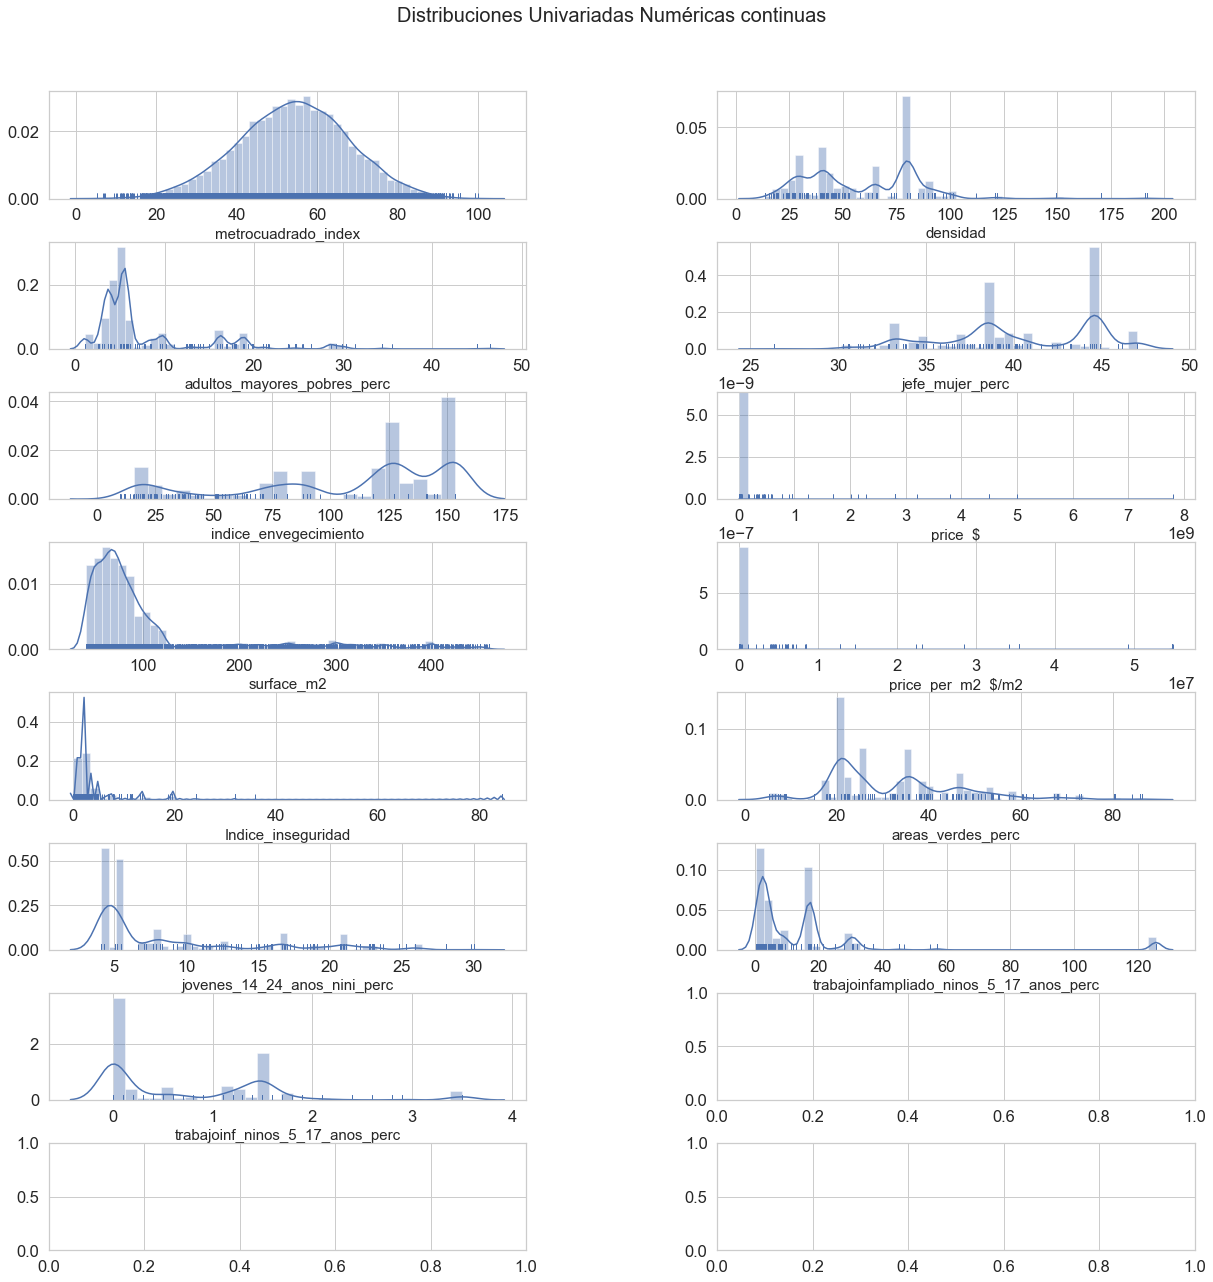

In [14]:
##### YA con el data reindexado, se proceden a obtener estadisticos de estos mismos
# para las variables numericas 

fig, ax = plt.subplots(nrows=8, ncols=2, figsize=[17, 17])

fig.tight_layout()
fig.suptitle('Distribuciones Univariadas Numéricas continuas',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), numeric_continuas):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric_continuas', col)], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric_continuas', col)], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)

In [15]:
# Para las variables catogoricas 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[17, 17])
fig.tight_layout()

fig.suptitle('Distribuciones Univariadas Categoricas',fontsize=20, x=0.5, y=1.05)

for axis, col in zip(ax.flatten(), categorical):
    try:
        sns.countplot(df[('categorical',col)], ax=axis)
    except: None
    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
    axis.set_xlabel(col, fontsize=15)

h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)

C:\Users\gabri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gabri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
Font 'default' does not have a glyph for '\r' [U+d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\r' [U+d], substituting with a dummy symbol.


Error in callback <function flush_figures at 0x000001BCB9A48A68> (for post_execute):


KeyboardInterrupt: 

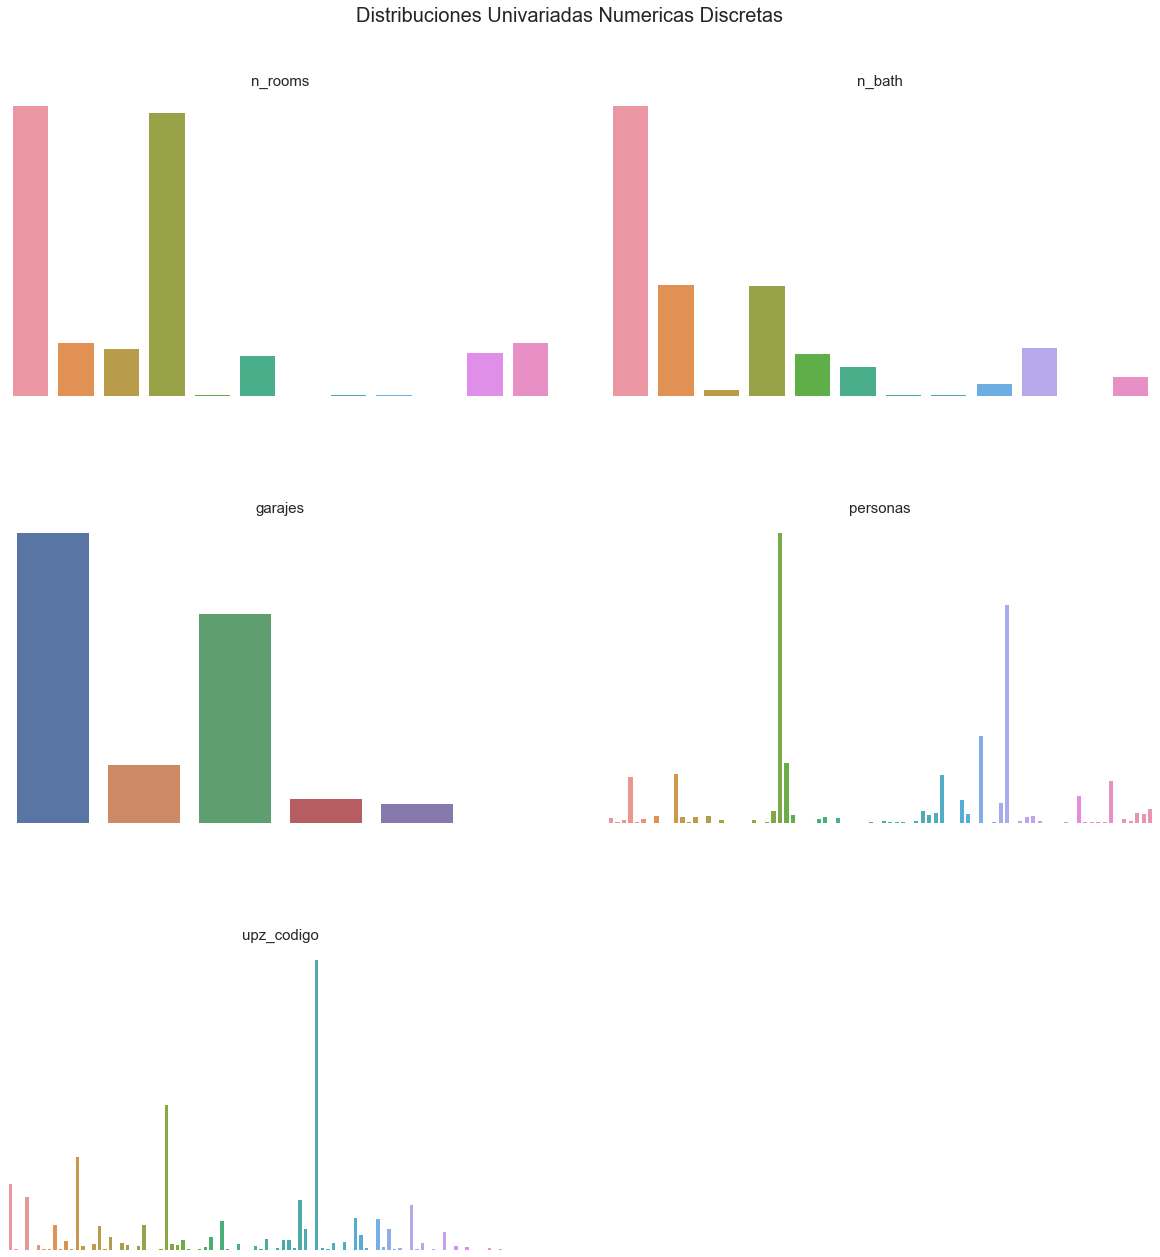

In [17]:
# PARA las variables numericas discretas, con upz agregada

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[17, 17])
fig.tight_layout()

fig.suptitle('Distribuciones Univariadas Numericas Discretas',
             fontsize=20,
             x=0.5,
             y=1.05)
list(map(lambda a : a.remove(), ax[-1,-1:]))

strings=['url','upz_codigo']
aux=strings
aux.remove('url')

numeric_aux=numeric_discretas+aux

for axis, col in zip(ax.flatten(), numeric_aux):
    try:
        sns.countplot(df[('numeric_discretas',col)], ax=axis)
    except:
        sns.countplot(df[('strings',col)], ax=axis)
    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
    axis.set_xlabel(col, fontsize=15)
h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)

In [19]:
def indexer(cols, t_c = df.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''
    
    set_to_tuple = set(*[cols])

    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    return tuples

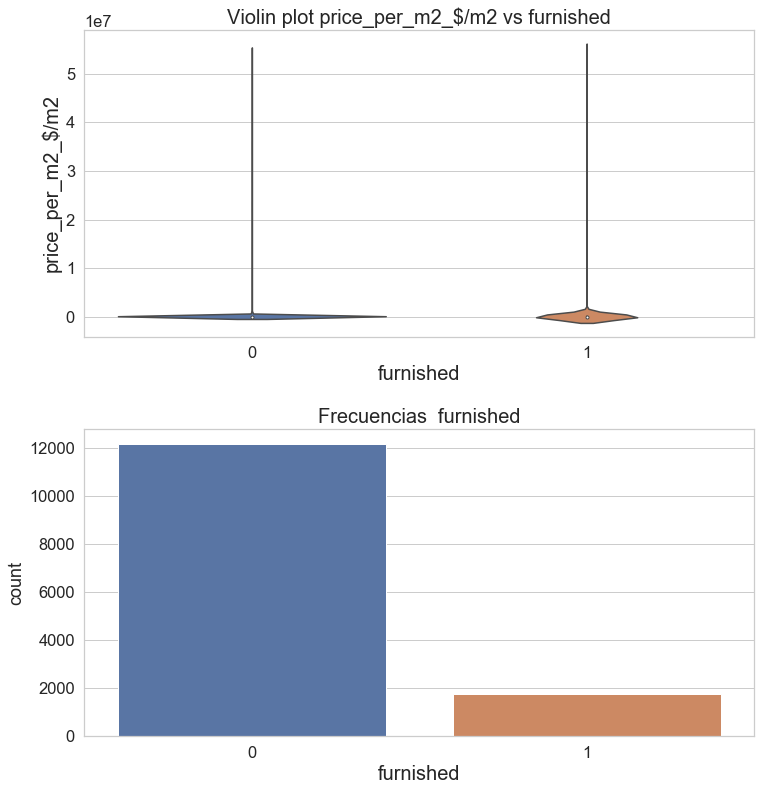

In [20]:
### se obtiene plots de variables categoricas interesantes

fontdict = {'fontsize':20}
fig, ax = plt.subplots(2,1,figsize=[12,13])

sns.violinplot(('categorical',  'furnished'),
            y=('numeric_continuas', 'price_per_m2_$/m2'),
            data=df,
            kind='violin',
            ax=ax[0])

sns.countplot(df[('categorical', 'furnished')], ax=ax[1])

ax[0].set_xlabel('furnished', fontdict)
ax[1].set_xlabel('furnished', fontdict)

ax[0].set_ylabel('price_per_m2_$/m2', fontdict)
ax[0].set_title('Violin plot price_per_m2_$/m2 vs furnished', fontdict)
ax[1].set_title('Frecuencias  furnished', fontdict)

h, w = (.3, .1)
plt.subplots_adjust(wspace=w, hspace=h)

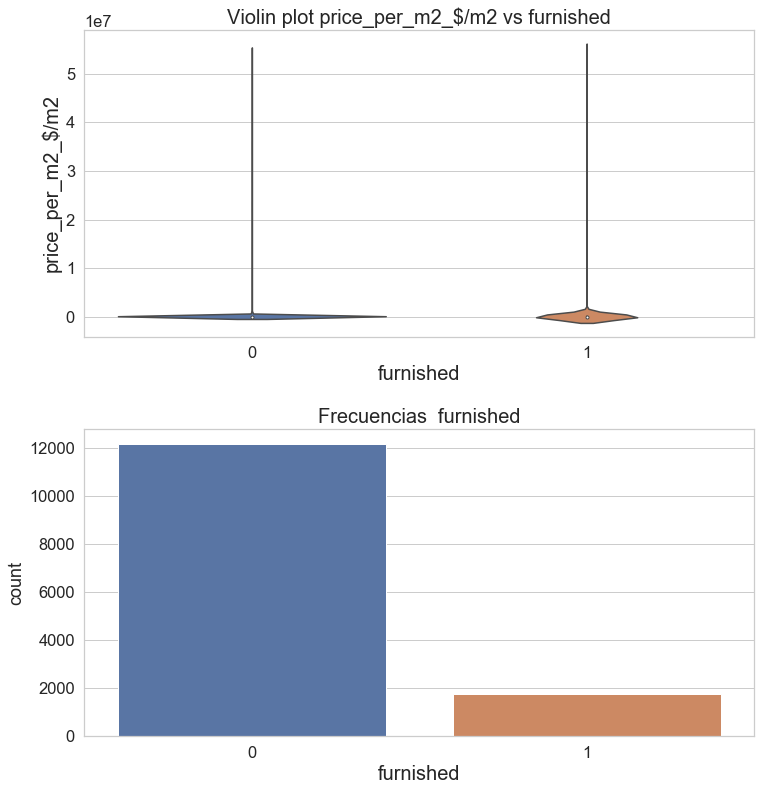

In [21]:
### se obtiene plots de variables categoricas interesantes

fontdict = {'fontsize':20}
fig, ax = plt.subplots(2,1,figsize=[12,13])

sns.violinplot(('categorical',  'furnished'),
            y=('numeric_continuas', 'price_per_m2_$/m2'),
            data=df,
            kind='violin',
            ax=ax[0])

sns.countplot(df[('categorical', 'furnished')], ax=ax[1])

ax[0].set_xlabel('furnished', fontdict)
ax[1].set_xlabel('furnished', fontdict)

ax[0].set_ylabel('price_per_m2_$/m2', fontdict)
ax[0].set_title('Violin plot price_per_m2_$/m2 vs furnished', fontdict)
ax[1].set_title('Frecuencias  furnished', fontdict)

h, w = (.3, .1)
plt.subplots_adjust(wspace=w, hspace=h)

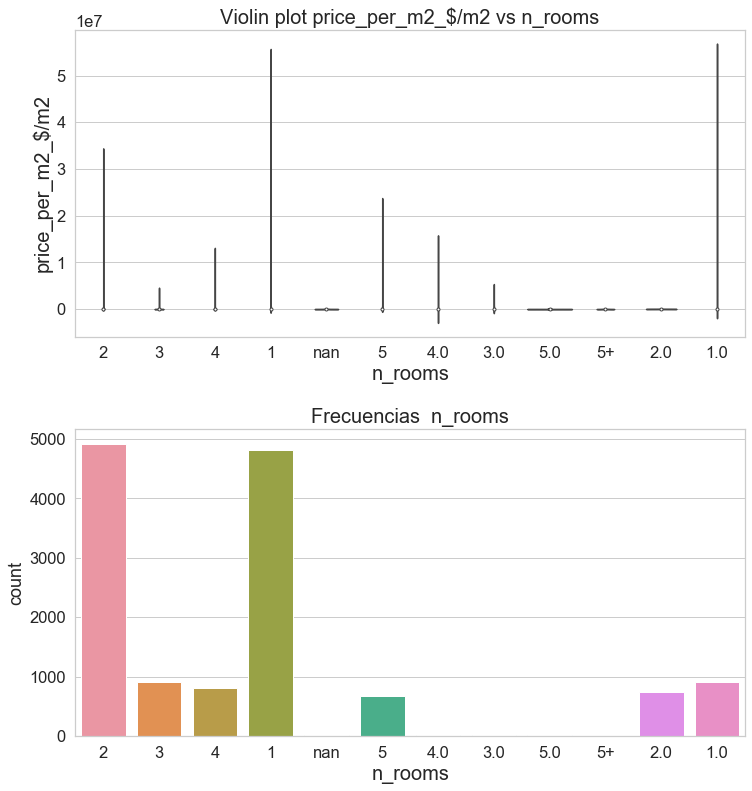

In [22]:
fontdict = {'fontsize':20}

fig, ax = plt.subplots(2,1,figsize=[12,13])

sns.violinplot(('numeric_discretas',  'n_rooms'),
            y=('numeric_continuas', 'price_per_m2_$/m2'),
            data=df,
            kind='violin',
            ax=ax[0])

sns.countplot(df[('numeric_discretas', 'n_rooms')], ax=ax[1])

ax[0].set_xlabel('n_rooms', fontdict)
ax[1].set_xlabel('n_rooms', fontdict)

ax[0].set_ylabel('price_per_m2_$/m2', fontdict)
ax[0].set_title('Violin plot price_per_m2_$/m2 vs n_rooms', fontdict)
ax[1].set_title('Frecuencias  n_rooms', fontdict)

h, w = (.3, .1)
plt.subplots_adjust(wspace=w, hspace=h)
    

KeyboardInterrupt: 

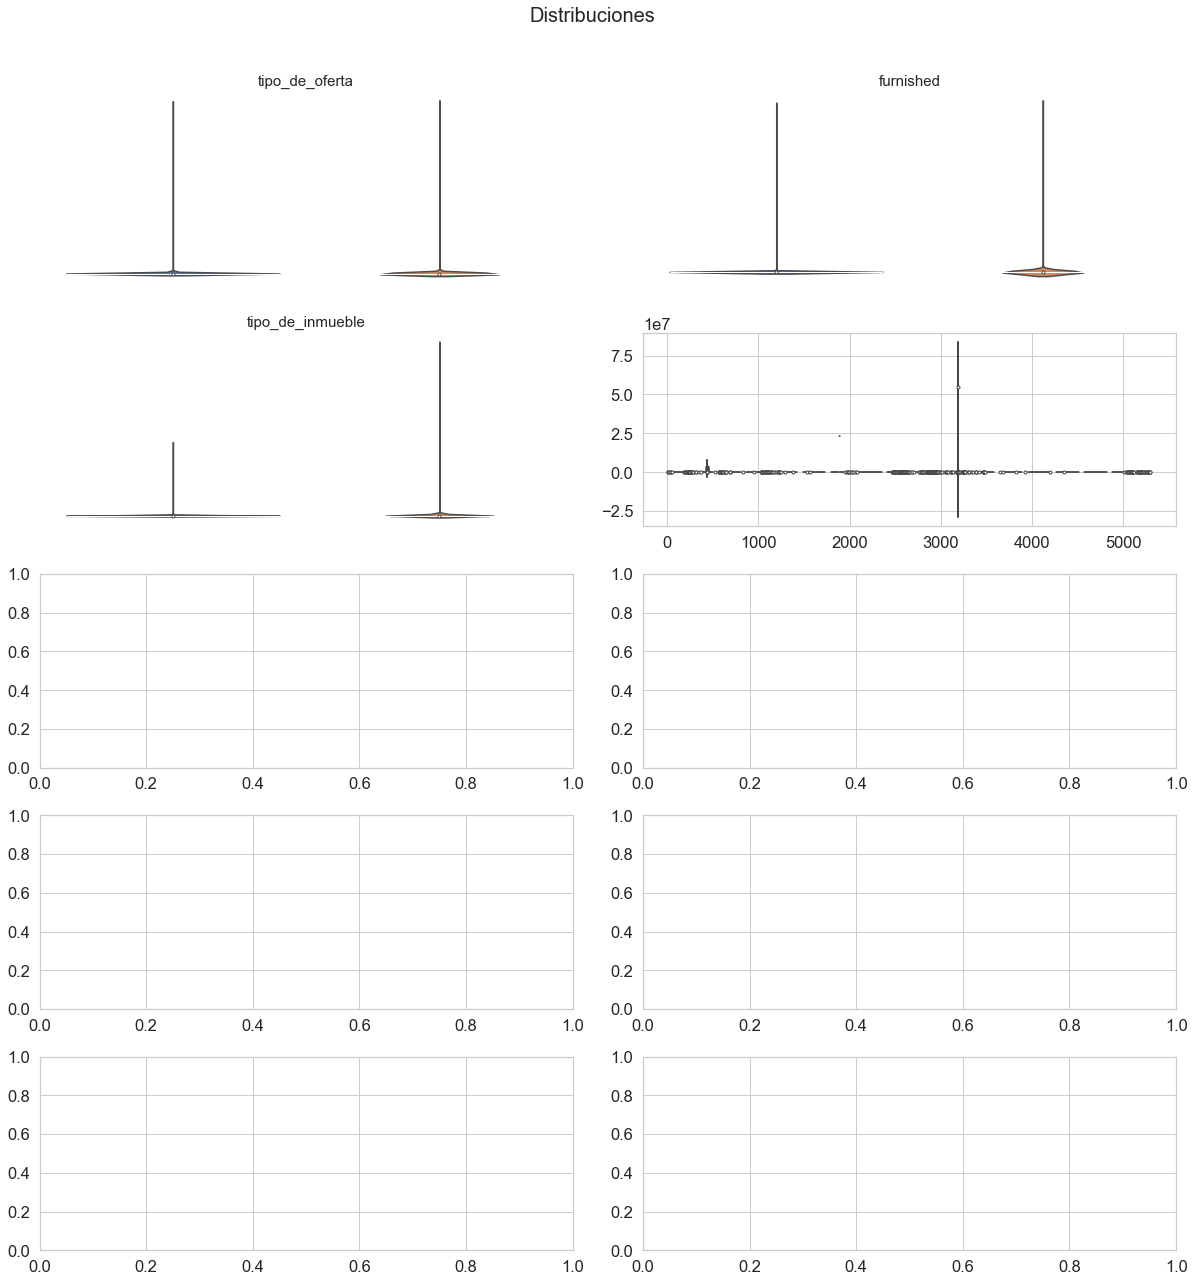

In [23]:
# no corrio
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=[17, 17])
fig.tight_layout()

fig.suptitle('Distribuciones', fontsize=20, x=0.5, y=1.05)

for axis, col in zip(ax.flatten(), categorical):
    sns.violinplot(('categorical',col), y=('numeric_continuas', 'price_per_m2_$/m2'), data=df, kind='violin', ax=axis)
    sns.countplot(df[('categorical',col)], ax=axis)

    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
    axis.set_xlabel(col, fontsize=15)

h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)

C:\Users\gabri\anaconda3\lib\site-packages\seaborn\axisgrid.py:1350: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=layout_pad)


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

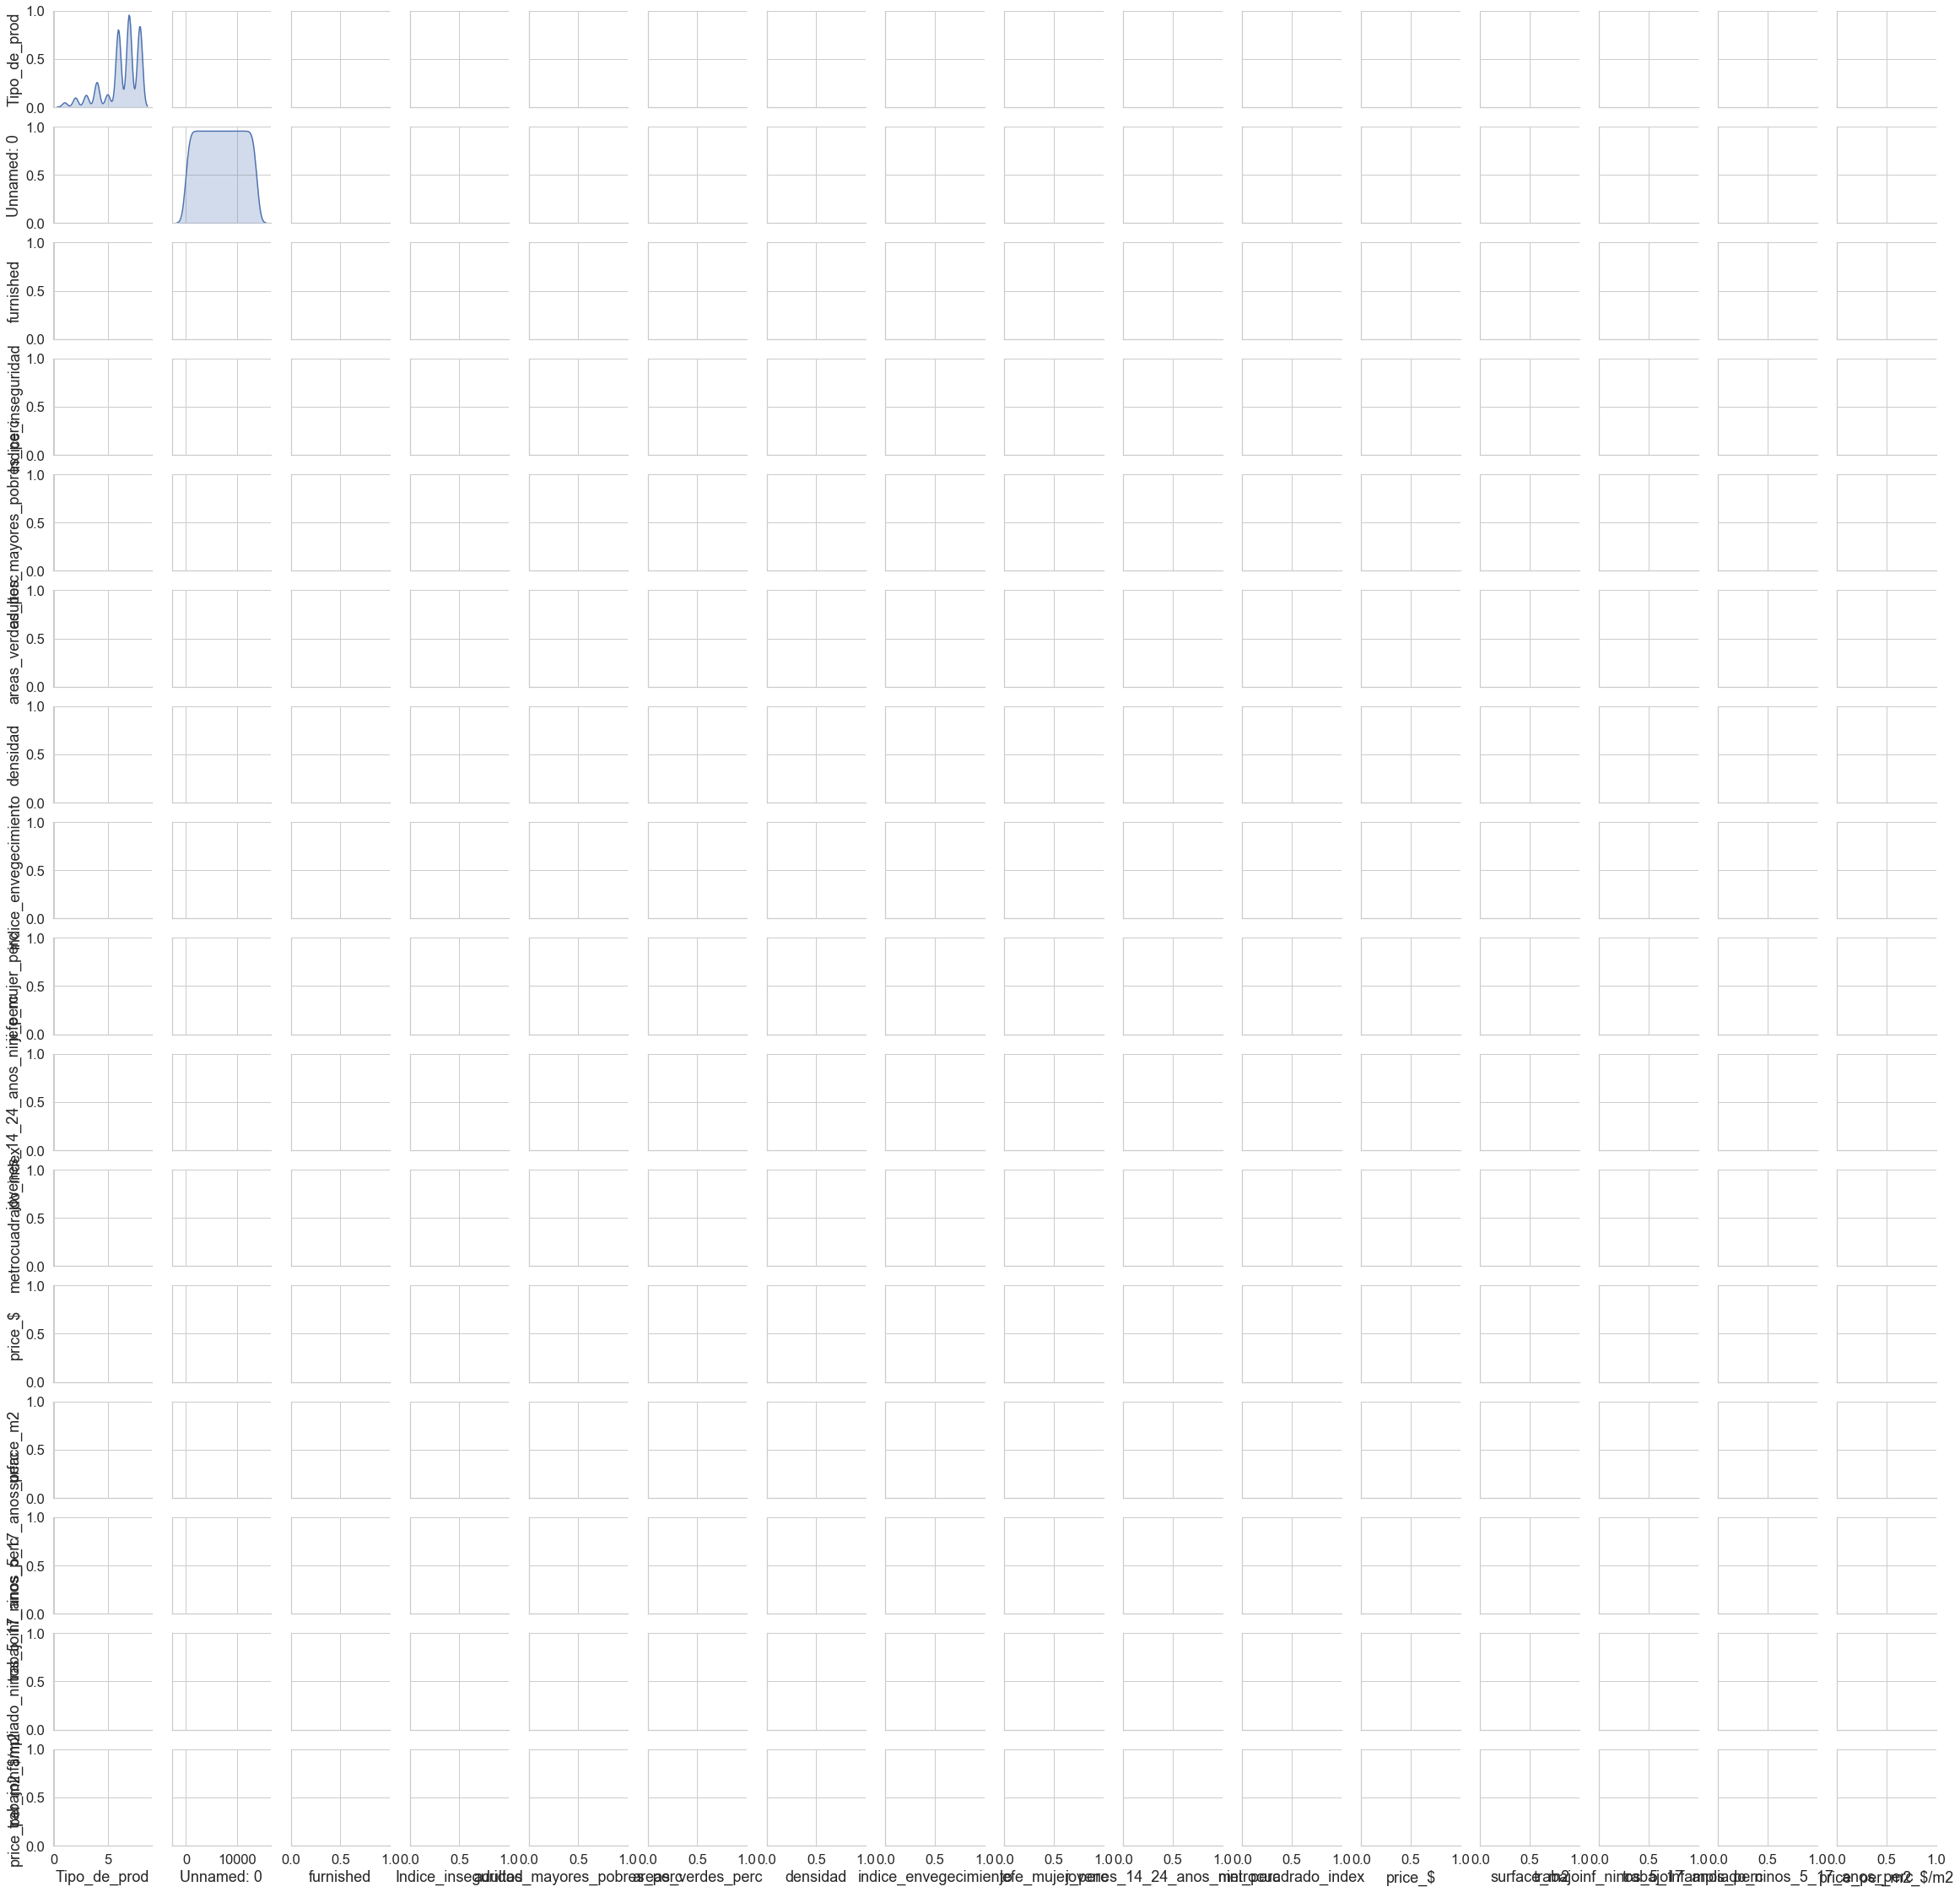

In [24]:
# tablas bivariada de variables continuas y categoricas
interest = numeric_continuas+categorical+aux
idxs = indexer(interest)

# se pone la variable de interes, en ultimo puesto
idxs.sort()
idxs.remove(('numeric_continuas', 'price_per_m2_$/m2'))
idxs.append(('numeric_continuas', 'price_per_m2_$/m2'))


data = df.reindex(idxs, axis=1).droplevel(0,axis=1)
sns.pairplot(data = data, diag_kind='kde')

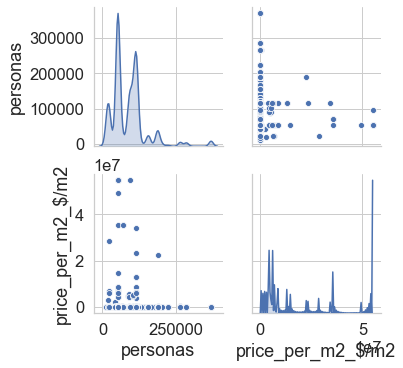

In [55]:
### tablas bivariada entre variables numericas, continuas y dicretas
interest2 = numeric_discretas + ['price_per_m2_$/m2']
idxs2 = indexer(interest2)

# se pone la variable de interes, en ultimo puesto
idxs2.sort()
idxs2.remove(('numeric_continuas', 'price_per_m2_$/m2'))
idxs2.append(('numeric_continuas', 'price_per_m2_$/m2'))

data2 = df.reindex(idxs2, axis=1).droplevel(0,axis=1)
sns.pairplot(data = data2, diag_kind='kde')

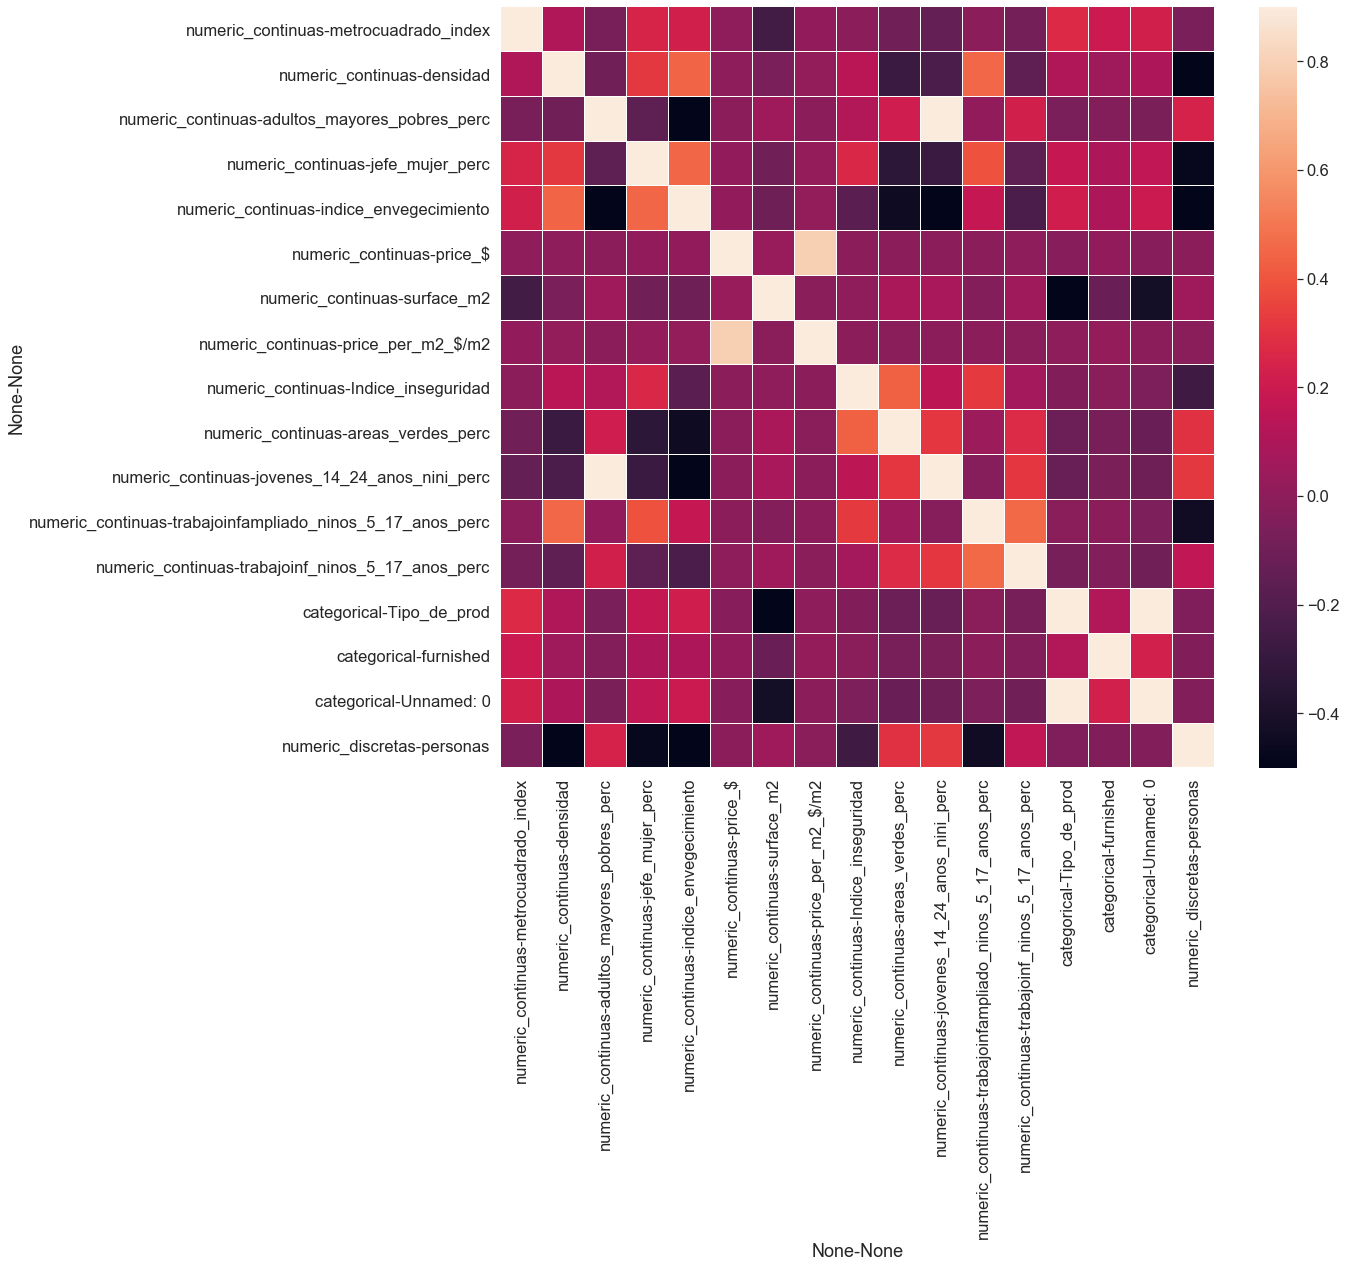

In [56]:
#### matriz de correlacion 
corrmat = df.corr()

unsorted = list(corrmat.columns)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corrmat.reindex(index = sortd, columns = sortd)

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [27]:
###### PARTE 3
import missingno as msno

# se obtienen valores faltantes

df.replace('nan',np.nan, inplace = True) 
df.isnull().sum()

numeric_continuas  metrocuadrado_index                          0
                   densidad                                     0
                   adultos_mayores_pobres_perc                  0
                   jefe_mujer_perc                              0
                   indice_envegecimiento                        0
                   price_$                                      0
                   surface_m2                                   0
                   price_per_m2_$/m2                            0
                   Indice_inseguridad                           0
                   areas_verdes_perc                            0
                   jovenes_14_24_anos_nini_perc                 0
                   trabajoinfampliado_ninos_5_17_anos_perc      0
                   trabajoinf_ninos_5_17_anos_perc              0
categorical        tipo_de_oferta                               0
                   furnished                                    0
          

C:\Users\gabri\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


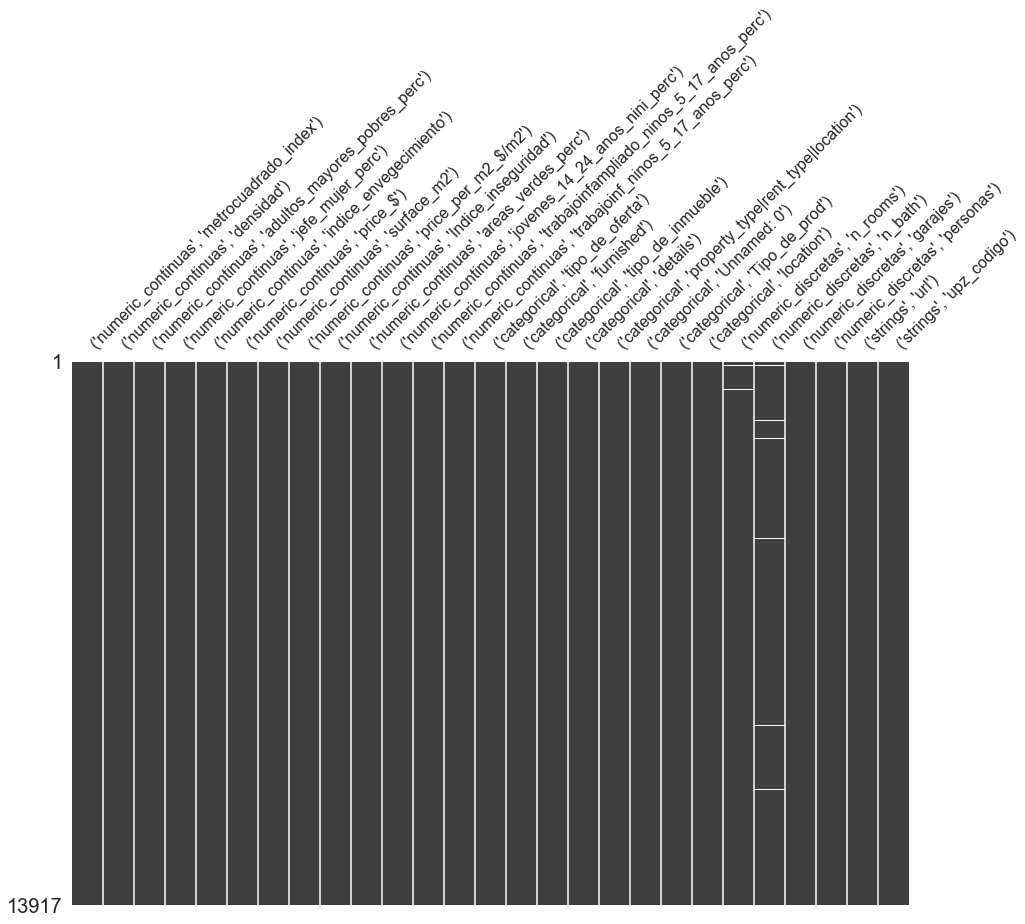

In [28]:
fig, ax = plt.subplots(1,1,figsize = [15, 10])
msno.matrix(df,ax = ax, sparkline=True)

Text(0.5, 1, 'Correlaciones de nulidad ')

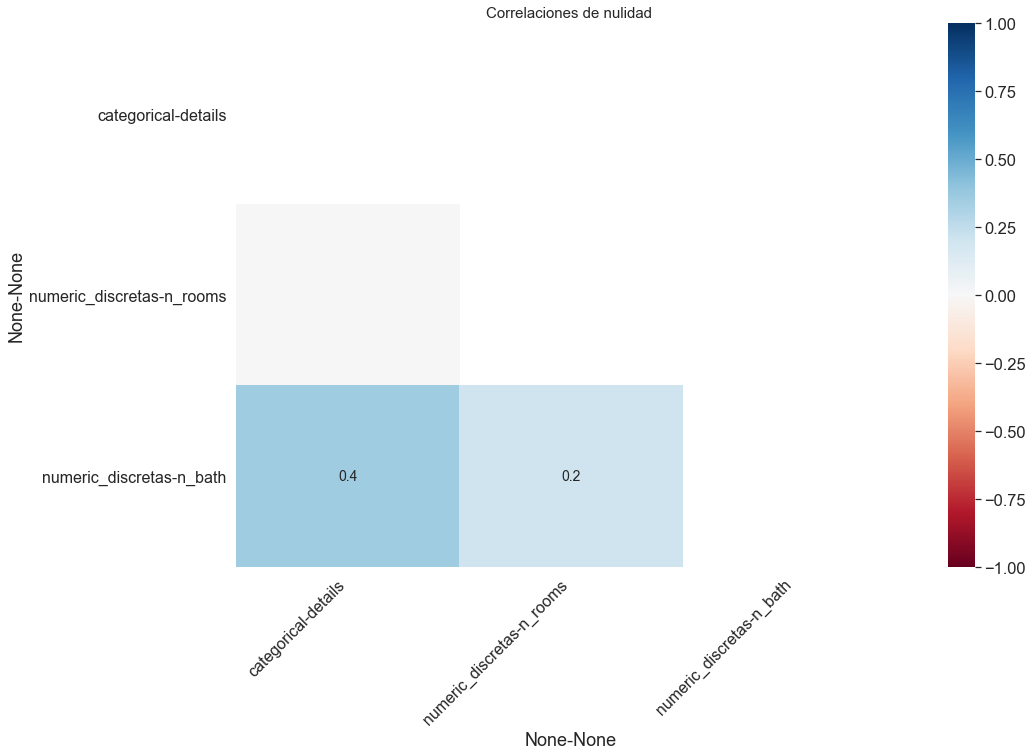

In [29]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax)
plt.title('Correlaciones de nulidad ', fontsize=15)

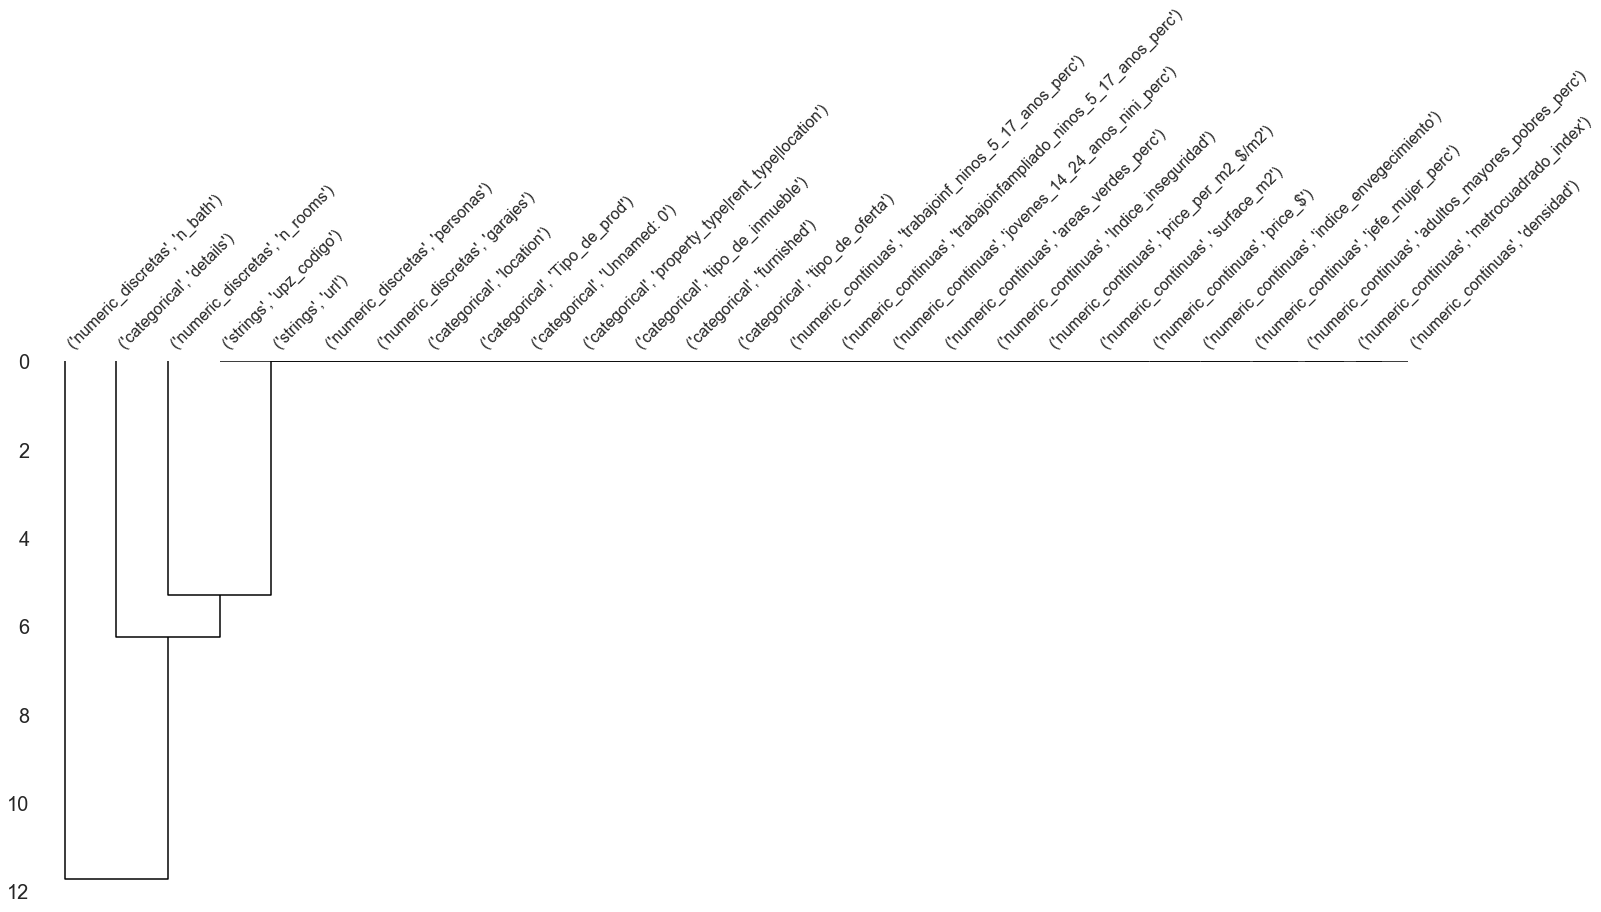

In [30]:
## se obtiene que varibales n_bath y details tienen cierta relacion, 
#en donde el hehco que que aparezca una hace que la otra este presenten en un factor de 0.4 
## idem analisis para n_bath y n_rooms con un factor de 0.2

## se obtiene dendograma
msno.dendrogram(df)

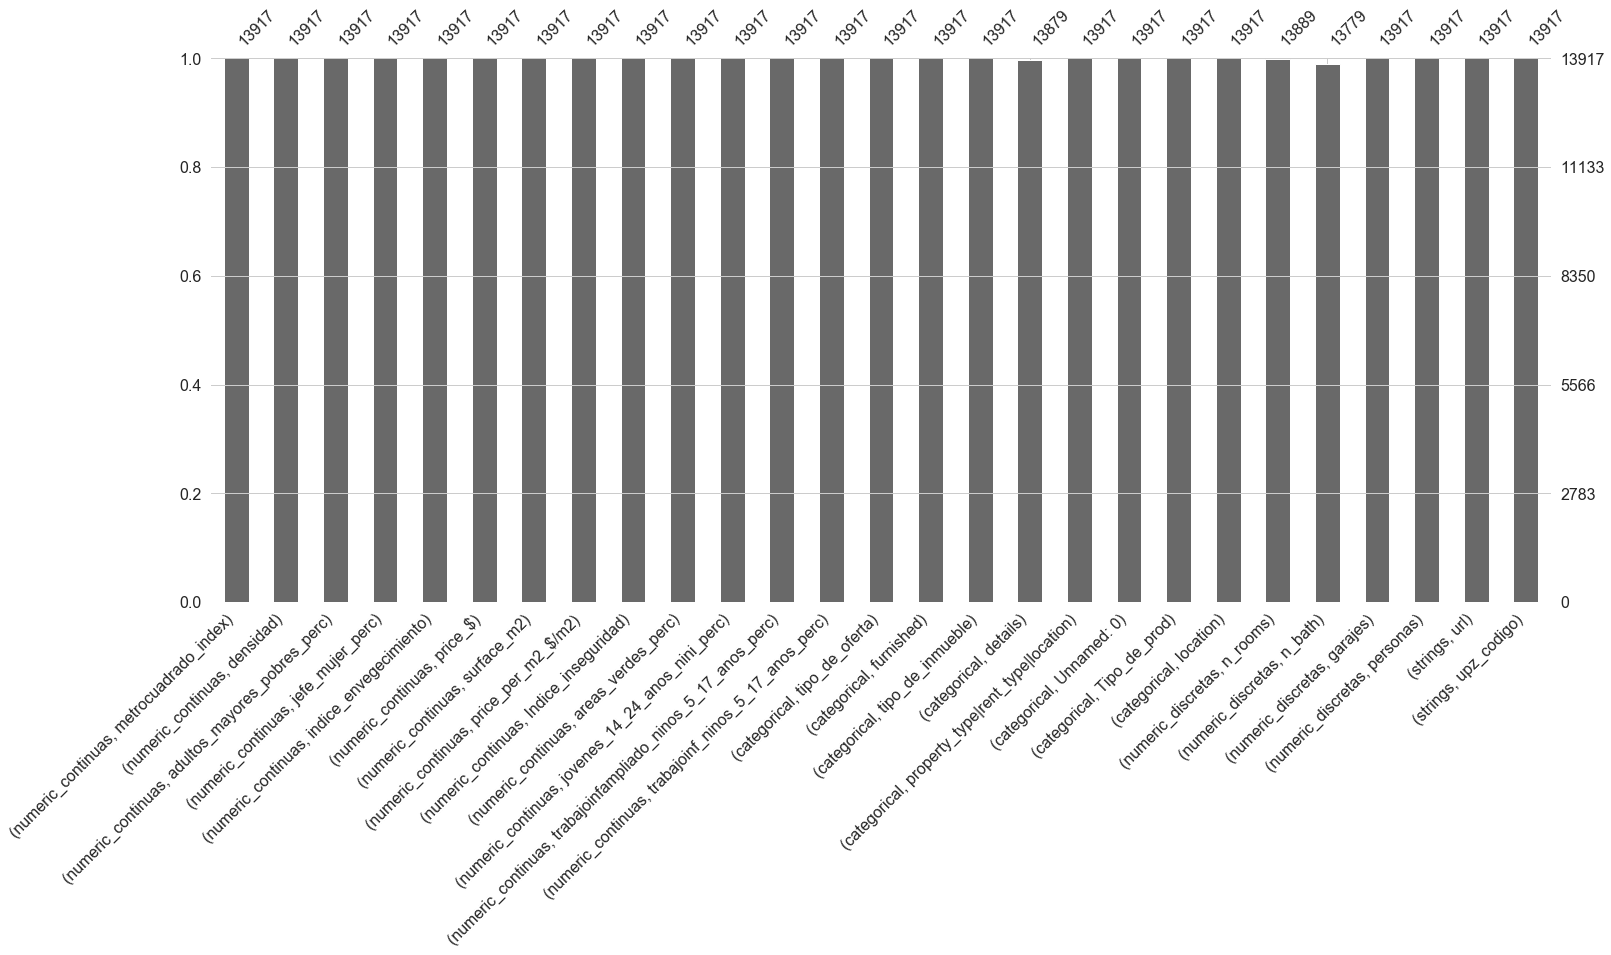

In [31]:
### COMO distribyen dichas variables
msno.bar(df)

In [31]:
##### PARTE 4

In [65]:
# llamamos a la columna de variable respuesta resp_col para hacer el k-means sobre todos los indices
resp_col = df[('numeric_continuas','price_per_m2_$/m2')]
# llamamos a la columna de codigos code col
code_col = df[('strings', 'upz_codigo')]
# Lista de promedios
promed = []
for code in set(code_col.tolist()):
    subselec = resp_col[code_col == code] 
    promed.append(np.mean(subselec))

In [71]:
promed_col = pd.DataFrame(data = {'repres_code': promed})

In [74]:
# importamos KMeans para hacer kmeans
from sklearn.cluster import KMeans
# se crea el modelo
kmeans = KMeans(n_clusters=5).fit(promed_col)
# se optimiza
labels_0 = kmeans.predict(promed_col) 

In [75]:
# lista con los codes sin repetir
list_code = list(set(code_col.tolist()))

In [76]:
# Creo las verdaderas etiquetas
labels = []
for index in range(len(code_col)):
    index_code = list_code.index(code_col[index])
    labels.append(labels_0[index_code])
# creo la columna
col_labels = pd.DataFrame(data = {'Cluster': labels}) 

In [79]:
# col_labels

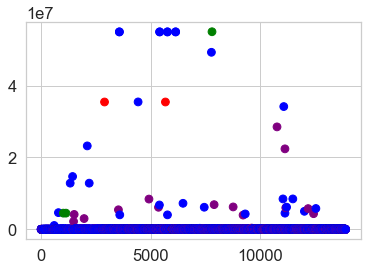

In [82]:
# Ahora se printean los resultados
fig, ax = plt.subplots()
colores=['blue','red','green','blue','purple']
asignar=[]
for row in range(len(col_labels)):
    asignar.append(colores[col_labels['Cluster'][row]])
ax.scatter(range(len(resp_col)), resp_col, c=asignar,s=60)

# centroids = kmeans.cluster_centers_
# print(centroids)
# plt.scatter(p[:,0], y[:,1])
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [ ]:
# Agrego la columna cluster al df dataset
df[('categorical', 'tipo_de_oferta')] = col_labels.tolist

In [84]:
#### parte 5

MultiIndex([('numeric_continuas',                     'metrocuadrado_index'),
            ('numeric_continuas',                                'densidad'),
            ('numeric_continuas',             'adultos_mayores_pobres_perc'),
            ('numeric_continuas',                         'jefe_mujer_perc'),
            ('numeric_continuas',                   'indice_envegecimiento'),
            ('numeric_continuas',                                 'price_$'),
            ('numeric_continuas',                              'surface_m2'),
            ('numeric_continuas',                       'price_per_m2_$/m2'),
            ('numeric_continuas',                      'Indice_inseguridad'),
            ('numeric_continuas',                       'areas_verdes_perc'),
            ('numeric_continuas',            'jovenes_14_24_anos_nini_perc'),
            ('numeric_continuas', 'trabajoinfampliado_ninos_5_17_anos_perc'),
            ('numeric_continuas',         'trabajoinf_ninos_5_17

# Pregunta 3: Implementación

## Parte 1
Se implementará la clase `RegresionBayesianaEmpirica`, que heredará las clases [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) y [`RegressorMixin`](http://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html), que son clases del paquete [`sklearn.base`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.base)

### Importaciones

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array

### Implementación de la clase `RegresionBayesianaEmpirica`

In [ ]:
class RegresionBayesianaEmpirica(RegressorMixin, BaseEstimator):
    """
    `RegresionBayesianaEmpirica` es una clase que hereda de `sklearn.base.BaseEstimator` y 
    `sklearn.base.RegressorMixin` el cual implementa la heurística enunciada en el 
    informe de la tarea para aproximar los hiperparámetros óptimos de alpha y beta.
    """
    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.alpha = alpha_0
        self.beta = beta_0
        self.__tol = tol
        self.__maxiter = maxiter
        
    def get_posterior(self, X, y, alpha, beta):
        """
        Recibe una matriz de observaciones 'X' (de dimensiones N x d), el vector de 
        etiquetas 'y' (de dimensión N) y los hiperparámetros 'alpha' y 'beta'.
        
        Retorna una tupla (m_N, S_N), dónde 'm_N' corresponde al vector de medias y 
        'S_N' corresponde a la matriz de covarianzas de la posterior de 'w'.
        """
        # Se ocupa P3-1
        # dimensiones
        N, d = X.shape
        
        # Matriz de covarianzas [d x d]
        S_N_inv = alpha*np.eye(d) + beta*X.T@X
        S_N = np.linalg.inv(S_N_inv) 
        
        # Vector de medias [d]
        m_N = beta * (S_N@X.T@y)
        
        return (m_N, S_N)
    
    def get_params(self, deep=True):
        return {'alpha': self.alpha, 'beta': self.beta}
    
    def fit(self, X, y):
        """
        Recibe una matriz de observaciones 'X' (de dimensiones N x d) 
        y un vector de etiquetas 'y' (de dimensión N).
        
        Ajusta los valores de 'alpha' y 'beta'.
        """
        print("Ajustando los valores de 'alpha' y 'beta'.")
        
        # Comprobamos que las dimensiones de X e y sean las correctas
        X, y = check_X_y(X, y)
        
        # Seteamos atributos de los datos y dimensiones
        self.X = X
        self.y = y
        self.N, self.d = self.X.shape
        
        maxiter_alcanzado = True # Variable para saber si la 
                                 # máxima iteración ha sido cumplida o no
        
        for itera in range(1, self.__maxiter+1):
            # Seteamos alpha_0 y beta_0 
            alpha_0, beta_0 = self.alpha, self.beta
            
            # Calculamos los valores propios de beta * X^t * X
            lamb, _ = np.linalg.eig(beta_0 * self.X.T@self.X)
            
            # Calculamos gamma
            gamma = sum([lamb[i] / (alpha_0 + lamb[i]) for i in range(self.d)])
            
            # Calculamos m_N
            m_N, S_N = self.get_posterior(self.X, self.y, alpha_0, beta_0)
            
            # Calculamos el siguiente valor de alpha
            alpha_1 = gamma / np.inner(m_N, m_N)
            
            # Y calculamos el siguiente valor de beta
            beta_1_inv = (1 / (self.N-gamma)) \
                     * sum([(self.y[i] - np.inner(m_N, self.X[i]))**2 for i in range(self.N)])
            beta_1 = 1 / beta_1_inv
            
            # Seteamos estos nuevos valores para alpha y beta
            self.alpha, self.beta = alpha_1, beta_1
            
            print(f"Para la iteración {itera}, los valores son:\n"
                  + "alpha:\t%.6f\n"%alpha_1 
                  + "beta:\t%.6f\n"%beta_1)
            
            # Comparamos para saber si ya se cumplió la condición de cercanía
            if (abs(alpha_0 - alpha_1) <= self.__tol
                and abs(beta_0 - beta_1) <= self.__tol):
                print(f'Tolerancia de {self.__tol} alcanzada.')
                maxiter_alcanzado = False
                break
        
        if maxiter_alcanzado:
            print(f'Número máximo de iteraciones {self.__maxiter} alcanzado.')
        
        print(f"Se termina el ajuste con {itera} iteraciones.")
        return self
            
    def predict(self, X_, return_std=False)->tuple:
        """
        Recibe una matriz de observaciones 'X_' (de dimensiones N' x d).
        
        Retorna una tupla (y_, y_std), en dónde 'y_' corresponde al vector de medias y 'y_std' 
        corresponde al vector de desviaciones estándar asociadas a las observaciones de 'X_'.
        Haciendo notar que esto ocurre solo sí 'return_std' es True. En caso contrario, solo retorna 
        la tupla (y_,).
        
        Se ocupa la distribución predictiva posterior para estas predicciones.
        """
        # Se ocupa P3-2
        
        # Asegurarse que ya se fijaron los parámetros
        check_is_fitted(self, ['alpha', 'beta'])
        
        # Validación del input
        X_ = check_array(X_)
        
        # Dimensiones necesarias
        N_, d = X_.shape
        m_N, S_N = self.get_posterior(self.X, self.y, self.alpha, self.beta)
        
        y_ = []
        y_std = []
        for i_ in range(N_):
            x_i = X_[i_]
            y_i = np.inner(m_N, x_i)
            y_std_i = 1/self.beta + x_i.T@S_N@x_i
            
            y_.append(y_i)
            y_std.append(y_std_i)
            
        if return_std:
            return (y_, y_std)
        else:
            return (y_,)


### Prueba de la clase

Se creará un data set de prueba para experimentar si la clase `RegresionBayesianaEmpirica` funciona. 

In [ ]:
# Módulos que quizas sean necesarios
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
from scipy.stats import multivariate_normal
import seaborn as sns # pretty plots
import numpy as np

#### Constantes

In [ ]:
N, d = 5000, 3
alpha_real, beta_real = 3, 4

#### Matriz `X`, vector `y` y vector de peso `w`

In [ ]:
w = np.array([3, 4, 5])

X = np.array([
    [1] + [np.random.uniform(-5, 5) for _ in range(d-1)] for _ in range(N)
])

y = np.array([
    float(np.inner(w, X[i]) + np.random.normal(0, alpha_real)) for i in range(N)
])

#### Prueba de la clase

In [ ]:
alpha_0, beta_0 = 50000, 2.5

rbe = RegresionBayesianaEmpirica(alpha_0, beta_0).fit(X, y)

#### Valor de `w_MAP`

In [ ]:
w_MAP, _ = rbe.get_posterior(X, y, rbe.alpha, rbe.beta)
w_MAP

#### Predicción

In [ ]:
X_ = np.array([
    [8, 2, 5],
    [2, 4, 9]
])
y_, y_std = rbe.predict(X_, return_std=True)
print(  f'y_:\t{y_}\n'
      + f'y_std:\t{y_std}')

In [ ]:
print(rbe.get_params())